In [76]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
import plotly.express as px
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from sklearn.linear_model import LinearRegression

In [62]:
data = pd.read_csv('data/flats.csv', index_col=0)
data.reset_index(drop=True, inplace=True)
data.head()

,price_doc,full_sq,life_sq,num_room,kitch_sq
0,2750000,11,11.0,1.0,12.0
1,7100000,45,27.0,2.0,6.0
2,11700000,77,50.0,3.0,8.0
3,10400000,56,29.0,2.0,10.0
4,6200000,31,21.0,1.0,5.0


## Предобработка данных

In [63]:
# Распределение целевого признака
fig = px.histogram(data['price_doc'], title='price_doc')
fig.show()

Избавляемся от выбросов

In [64]:
data['price_doc'] = data['price_doc'].apply(lambda x: np.log(x+1))

In [65]:
iqr = np.percentile(data['price_doc'], 75) - np.percentile(data['price_doc'], 25)
data = data[(data['price_doc']>(np.percentile(data['price_doc'], 25) - 2.5*iqr))&(data['price_doc']<(np.percentile(data['price_doc'], 75) + 2.5*iqr))]

In [66]:
print(f'Оставшееся количество строк: {data.shape[0]}')

Оставшееся количество строк: 5745


In [67]:
for i in data.columns:
    fig = px.histogram(data[i], title=i)
    fig.show()

In [68]:
stats.shapiro(data['price_doc'])

c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



ShapiroResult(statistic=0.9631249904632568, pvalue=6.347658015003333e-36)

После логарифмирования целевой переменной распределение стало похоже на нормальное, но по тестированию по прежнему остаётся ненормальным... судя по смыслу задания предполагается считать данное распределение условно нормальным. Остальные признаки имеют логнормальное распределение, кроме количества комнат.

## Модели

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
C:\Users\anzel\AppData\Local\Temp\ipykernel_8436\1316774854.py:3: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, kitch_sq, num_room, life_sq, full_sq, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
The acceptance probability does not match the target. It is 0.9457344005583739, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



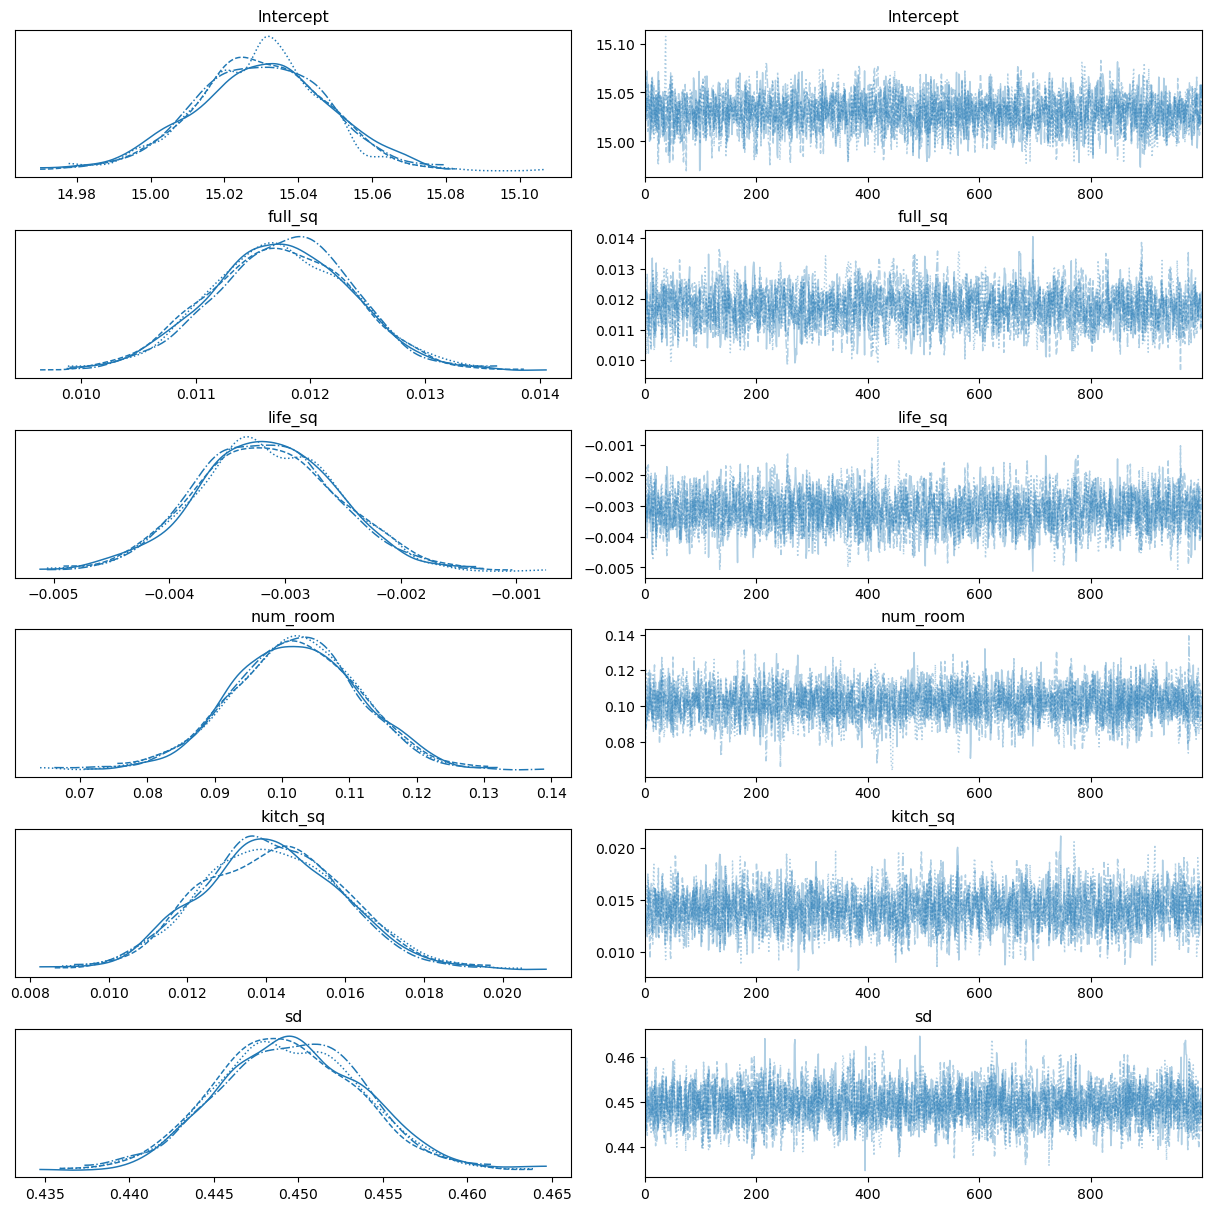

In [72]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('price_doc ~ full_sq + life_sq + num_room + kitch_sq', data, family = pm.glm.families.Normal())
    trace = pm.sample(1000)
    
az.plot_trace(trace);

In [77]:
lr = LinearRegression()
lr.fit(data[['full_sq', 'life_sq', 'num_room', 'kitch_sq']], data['price_doc'])

LinearRegression()

In [78]:
lr.intercept_

15.02951545400731

In [81]:
pd.DataFrame(lr.coef_, index=['full_sq', 'life_sq', 'num_room', 'kitch_sq'])

,0
full_sq,0.011717
life_sq,-0.003139
num_room,0.102211
kitch_sq,0.014137


In [82]:
pm.summary(trace)

c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.030,0.018,14.994,15.061,0.0,0.0,2741.0,2727.0,1.0
full_sq,0.012,0.001,0.011,0.013,0.0,0.0,1997.0,2035.0,1.0
life_sq,-0.003,0.001,-0.004,-0.002,0.0,0.0,2386.0,2406.0,1.0
num_room,0.102,0.009,0.085,0.120,0.0,0.0,2760.0,2619.0,1.0
kitch_sq,0.014,0.002,0.011,0.017,0.0,0.0,2915.0,2795.0,1.0
sd,0.449,0.004,0.442,0.457,0.0,0.0,3327.0,2231.0,1.0


Коэффициенты почти одинаковы.